In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
from collections import deque
import os
import pickle

# Exploration

In [2]:
filename = 'train_low_mem.parquet'

In [3]:
df = pd.read_parquet(filename)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3141410 entries, 0 to 3141409
Columns: 304 entries, row_id to f_299
dtypes: float32(301), object(1), uint16(2)
memory usage: 3.6+ GB


Very large file when creating the sequences
-> use float 16 as dtype & not too long sequences (size will increase times the sequence length)

In [5]:
df.head()

,row_id,time_id,investment_id,target,f_0,f_1,f_2,f_3,f_4,f_5,...,f_290,f_291,f_292,f_293,f_294,f_295,f_296,f_297,f_298,f_299
0,0_1,0,1,-0.300875,0.932573,0.113691,-0.402206,0.378386,-0.203938,-0.413469,...,0.366028,-1.095620,0.200075,0.819155,0.941183,-0.086764,-1.087009,-1.044826,-0.287605,0.321566
1,0_2,0,2,-0.231040,0.810802,-0.514115,0.742368,-0.616673,-0.194255,1.771210,...,-0.154193,0.912726,-0.734579,0.819155,0.941183,-0.387617,-1.087009,-0.929529,-0.974060,-0.343624
2,0_6,0,6,0.568807,0.393974,0.615937,0.567806,-0.607963,0.068883,-1.083155,...,-0.138020,0.912726,-0.551904,-1.220772,-1.060166,-0.219097,-1.087009,-0.612428,-0.113944,0.243608
3,0_7,0,7,-1.064780,-2.343535,-0.011870,1.874606,-0.606346,-0.586827,-0.815737,...,0.382201,0.912726,-0.266359,-1.220772,0.941183,-0.609113,0.104928,-0.783423,1.151730,-0.773309
4,0_8,0,8,-0.531940,0.842057,-0.262993,2.330030,-0.583422,-0.618392,-0.742814,...,-0.170365,0.912726,-0.741355,-1.220772,0.941183,-0.588445,0.104928,0.753279,1.345611,-0.737624


In [6]:
pd.set_option("display.max_rows", 10)

In [7]:
df['time_id'].value_counts(ascending=False)
#left: unique value; right: how often

1214    3445
1209    3444
1211    3440
1207    3440
1208    3438
        ... 
415      659
362      651
374      600
398      539
492      512
Name: time_id, Length: 1211, dtype: int64

One time_id each is feeded for the evaluation, so picking sequences of 128 seems reasonable (smallest 512, most > 2000)

In [8]:
df.describe()

,time_id,investment_id,target,f_0,f_1,f_2,f_3,f_4,f_5,f_6,...,f_290,f_291,f_292,f_293,f_294,f_295,f_296,f_297,f_298,f_299
count,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,...,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06
mean,6.654862e+02,1.885265e+03,-2.109159e-02,1.637057e-03,-1.257678e-02,8.514749e-03,-2.003703e-02,-5.416438e-03,-3.034008e-03,1.934330e-03,...,1.256709e-02,9.002053e-04,-6.509154e-03,2.851608e-03,-4.730820e-03,-2.773806e-02,-1.517383e-03,-7.057928e-03,-4.216896e-03,-4.319488e-03
std,3.560434e+02,1.083616e+03,9.176629e-01,1.079721e+00,1.030980e+00,1.030281e+00,9.602916e-01,9.895188e-01,1.104578e+00,1.067755e+00,...,1.084496e+00,1.114387e+00,1.070176e+00,1.101158e+00,1.144516e+00,9.592550e-01,1.140459e+00,1.108097e+00,1.051252e+00,1.008220e+00
min,0.000000e+00,0.000000e+00,-9.419646e+00,-1.765789e+01,-6.579473e+00,-8.644268e+00,-1.800427e+01,-4.000015e+00,-8.833704e+00,-6.384251e+00,...,-9.271487e+00,-6.359966e+00,-8.183732e+00,-2.399478e+01,-1.497270e+01,-9.348986e+00,-7.366648e+00,-7.579406e+00,-6.707284e+00,-1.028264e+01
25%,3.530000e+02,9.520000e+02,-5.004572e-01,-4.071441e-01,-6.813878e-01,-6.530838e-01,-4.496046e-01,-3.532303e-01,-7.070855e-01,-7.911198e-01,...,-6.037326e-01,-8.355157e-01,-6.981400e-01,-1.377131e-01,-9.397985e-01,-5.147926e-01,-9.573807e-01,-7.239380e-01,-8.165390e-01,-5.080143e-01
50%,7.040000e+02,1.882000e+03,-9.717009e-02,2.431158e-01,-4.867587e-02,4.350941e-02,-2.639937e-01,-1.908876e-01,-2.144796e-02,1.437945e-02,...,6.086323e-02,-2.023181e-01,-1.910102e-01,2.164071e-01,2.087202e-01,-2.907780e-01,6.955573e-03,-1.650222e-01,2.300689e-02,-2.824031e-01
75%,9.750000e+02,2.830000e+03,3.572908e-01,6.649507e-01,6.086557e-01,6.587324e-01,7.763371e-02,2.784694e-02,6.835684e-01,8.008306e-01,...,6.882384e-01,9.035954e-01,4.841421e-01,5.088849e-01,8.616266e-01,1.275946e-01,9.503851e-01,6.098197e-01,7.984827e-01,1.411301e-01
max,1.219000e+03,3.773000e+03,1.203861e+01,7.845261e+00,8.707207e+00,8.009340e+00,4.706333e+01,7.662866e+01,7.646200e+00,6.778142e+00,...,9.298274e+00,9.725060e+00,2.231185e+01,6.587691e+00,6.978151e+00,6.140367e+01,7.679950e+00,1.241804e+01,7.003982e+00,4.337021e+01


Each feature has a mean around 0 and a std. around 1 -> no scaling needed

(array([0.00000e+00, 1.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 1.00000e+00, 1.00000e+00, 0.00000e+00,
        8.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 2.00000e+00, 1.00000e+00, 3.00000e+00, 3.00000e+00,
        2.00000e+00, 2.00000e+00, 4.00000e+00, 4.00000e+00, 8.00000e+00,
        5.00000e+00, 3.00000e+00, 7.00000e+00, 1.70000e+01, 1.30000e+01,
        1.90000e+01, 2.40000e+01, 3.30000e+01, 5.00000e+01, 4.40000e+01,
        7.30000e+01, 7.30000e+01, 8.80000e+01, 1.24000e+02, 1.41000e+02,
        1.79000e+02, 2.39000e+02, 3.36000e+02, 3.82000e+02, 4.84000e+02,
        5.84000e+02, 7.20000e+02, 8.97000e+02, 1.12100e+03, 1.45500e+03,
        1.79700e+03, 2.25200e+03, 2.81400e+03, 3.68100e+03, 4.41100e+03,
        5.61200e+03, 6.83600e+03, 8.54100e+03, 1.09220e+04, 1.33300e+04,
        1.65300e+04, 2.12200e+04, 2.67020e+04, 3.37400e+04, 4.32170e+04,
        5.51550e+04, 7.17200e+04, 9.35690e+04, 1.22

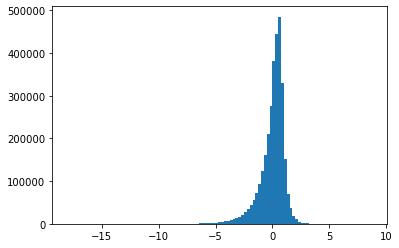

In [9]:
#distribution of feature f_0
categories = list(range(-18*4, 9*4, 1))
categories = [i / 4 for i in categories]
plt.hist(df['f_0'], categories)

(array([0.00000e+00, 0.00000e+00, 1.00000e+00, 1.00000e+00, 1.00000e+00,
        0.00000e+00, 2.00000e+00, 9.00000e+00, 7.00000e+00, 7.00000e+00,
        1.40000e+01, 2.40000e+01, 2.50000e+01, 4.10000e+01, 6.30000e+01,
        8.60000e+01, 1.12000e+02, 1.43000e+02, 1.54000e+02, 2.44000e+02,
        3.26000e+02, 4.27000e+02, 6.43000e+02, 7.74000e+02, 1.07000e+03,
        1.46300e+03, 2.06800e+03, 2.89000e+03, 4.15100e+03, 6.08200e+03,
        8.98800e+03, 1.39990e+04, 2.22150e+04, 3.66700e+04, 6.24110e+04,
        1.09372e+05, 1.90721e+05, 3.20847e+05, 4.65146e+05, 5.21415e+05,
        4.39403e+05, 3.00246e+05, 1.96018e+05, 1.28122e+05, 8.55870e+04,
        5.90450e+04, 4.13010e+04, 2.94480e+04, 2.12360e+04, 1.57060e+04,
        1.16610e+04, 8.84900e+03, 6.76500e+03, 5.19800e+03, 4.04600e+03,
        3.29100e+03, 2.64100e+03, 2.16700e+03, 1.75600e+03, 1.48600e+03,
        1.18200e+03, 9.43000e+02, 6.76000e+02, 5.58000e+02, 4.39000e+02,
        3.28000e+02, 2.09000e+02, 1.55000e+02, 1.00

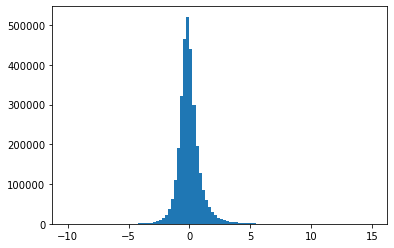

In [10]:
#distribution of the target -> balancing neccessary?
categories_target = list(range(-40, 61, 1))
categories_target = [i / 4 for i in categories_target]
plt.hist(df['target'], categories_target)

In [11]:
print(df['target'].mean())
print(df['target'].median())

-0.021091585978865623
-0.09717009216547012


In [12]:
targets_above_0 = 0
for i in df['target']:
    if i > 0:
        targets_above_0 += 1

targets_below_0 = 0
for i in df['target']:
    if i < 0:
        targets_below_0 += 1
        
print('targets_below_0: ', targets_below_0)
print('targets_above_0: ', targets_above_0)

targets_below_0:  1772612
targets_above_0:  1367062


Little imbalance but the evaluation is based on the mean correlation, so it should be fine

In [13]:
df.drop(['row_id', 'time_id', 'investment_id'], axis=1, inplace=True)

In [14]:
#float16 for less memory usage
df = df.astype('float16')

# Splitting the data

For time series its important to use big chunks with no overlapping (otherwise overfit)

Devide the whole dataset into 11 pieces: Val_1, Test_1, Train_1, Val_2, Test_2, Train_2, Val_3, Test_3, Train_3, Val_4, Test_4

Each validation-set & test-set 5%; each training-set 20% -> Val: 20%; Test: 20%; Train: 60%

In [15]:
df.index

RangeIndex(start=0, stop=3141410, step=1)

In [16]:
#last indices of each split
valid_index_1 = int(0.05 * len(df))  #first 5%
test_index_1 = int(0.1 * len(df))  # 5-10%
train_index_1 = int(0.3 * len(df))  # 10-30%

valid_index_2 = int(0.35 * len(df))  #30-35%
test_index_2 = int(0.4 * len(df))  # 35-40%
train_index_2 = int(0.6 * len(df))  # 40-60%

valid_index_3 = int(0.65 * len(df))  #60-65%
test_index_3 = int(0.7 * len(df))  # 65-70%
train_index_3 = int(0.9 * len(df))  # 70-90%

valid_index_4 = int(0.95 * len(df))  #90-95%
test_index_4 = int(1 * len(df))  # 95-100%

In [17]:
valid_1_X = df.filter(items=list(range(valid_index_1)), axis=0)
test_1_X = df.filter(items=list(range(valid_index_1, test_index_1)), axis=0)
train_1_X = df.filter(items=list(range(test_index_1, train_index_1)), axis=0)

valid_2_X = df.filter(items=list(range(train_index_1, valid_index_2)), axis=0)
test_2_X = df.filter(items=list(range(valid_index_2, test_index_2)), axis=0)
train_2_X = df.filter(items=list(range(test_index_2, train_index_2)), axis=0)

valid_3_X = df.filter(items=list(range(train_index_2, valid_index_3)), axis=0)
test_3_X = df.filter(items=list(range(valid_index_3, test_index_3)), axis=0)
train_3_X = df.filter(items=list(range(test_index_3, train_index_3)), axis=0)

valid_4_X = df.filter(items=list(range(train_index_3, valid_index_4)), axis=0)
test_4_X = df.filter(items=list(range(valid_index_4, test_index_4)), axis=0)

In [18]:
valid_1_X.tail(2)

,target,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,...,f_290,f_291,f_292,f_293,f_294,f_295,f_296,f_297,f_298,f_299
157068,0.120361,1.155273,-0.508789,0.710449,-0.929688,2.574219,2.166016,0.486328,-1.519531,0.796875,...,0.934082,-1.792969,2.011719,0.576172,-1.983398,1.865234,1.442383,-1.222656,-0.199463,-1.023438
157069,3.648438,1.005859,0.194702,0.861816,0.479492,-0.586426,0.224976,-2.216797,0.965332,0.064575,...,-0.582520,2.154297,-0.336914,0.073730,0.407471,-0.277832,0.472412,1.784180,0.526367,-0.750977


In [19]:
test_1_X.head(2)

,target,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,...,f_290,f_291,f_292,f_293,f_294,f_295,f_296,f_297,f_298,f_299
157070,2.023438,0.084900,0.660645,-1.836914,1.383789,0.733887,2.519531,-0.374268,-0.202759,-0.351074,...,0.776855,1.384766,2.283203,-0.083862,-0.057526,1.884766,-2.134766,-1.197266,0.588379,1.943359
157071,0.572266,-0.413086,0.255615,-0.786133,0.651855,-0.365723,0.047089,0.733398,-1.172852,0.056854,...,1.696289,-0.931641,1.614258,-0.190063,2.896484,0.050568,-1.044922,-0.409912,0.970215,0.190552


In [20]:
#separate the targets from the features
valid_1_y = valid_1_X.pop('target')
test_1_y = test_1_X.pop('target')
train_1_y = train_1_X.pop('target')

valid_2_y = valid_2_X.pop('target')
test_2_y = test_2_X.pop('target')
train_2_y = train_2_X.pop('target')

valid_3_y = valid_3_X.pop('target')
test_3_y = test_3_X.pop('target')
train_3_y = train_3_X.pop('target')

valid_4_y = valid_4_X.pop('target')
test_4_y = test_4_X.pop('target')

In [21]:
valid_1_X.columns

Index(['f_0', 'f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9',
       ...
       'f_290', 'f_291', 'f_292', 'f_293', 'f_294', 'f_295', 'f_296', 'f_297',
       'f_298', 'f_299'],
      dtype='object', length=300)

In [22]:
valid_1_y.name

'target'

In [23]:
valid_1_X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 157070 entries, 0 to 157069
Columns: 300 entries, f_0 to f_299
dtypes: float16(300)
memory usage: 91.1 MB


Function for preprocessing the dataframe. Takes as Input the slices (features, targets), creates the sequences of length 128 and dumps smaller pieces in a directory

In [24]:
def preprocess_slices(X, y, X_name, y_name, dir_name, seq_len=128):
    if os.path.exists(dir_name) == False:  # create dirs if not there yet
        os.mkdir(dir_name)
    
    X = X.values  # transform into array
    y = y.values
    
    seq_X = []  # list for the resulting data pieces
    seq_y = []
    
    last_values = deque(maxlen=seq_len)  # deque for creating the sequences
    
    file_num = 0  # filenumber for unique name
    
    for row, target in zip(X, y):  # iterate parallel over the features and the target

        last_values.append(row)  # append the que with the current features
        
        if len(last_values) == seq_len:  # if queue has enough values, append to results
            seq_X.append(last_values)
            seq_y.append(target)  # current target
            
        if len(seq_X) == 31_414:  # save every 31414 rows -> len(df)/31414 ~ 0 -> no wasted data 
            file_num += 1
            
            seq_X = np.array(seq_X)  # save an array
            seq_y = np.array(seq_y)
            
            with open(f"{dir_name}/{X_name}_{file_num}.pickle", "wb") as out:
                pickle.dump(seq_X, out, protocol=4)
            with open(f"{dir_name}/{y_name}_{file_num}.pickle", "wb") as out:
                pickle.dump(seq_y, out, protocol=4)
        
            seq_X = []  # empty the results for the next iteration
            seq_y = []
    
    print(f'Created {file_num} files')

In [25]:
preprocess_slices(X=valid_1_X, y=valid_1_y, X_name='valid_1_X', y_name='valid_1_y', dir_name='valid')
preprocess_slices(X=valid_2_X, y=valid_2_y, X_name='valid_2_X', y_name='valid_2_y', dir_name='valid')
preprocess_slices(X=valid_3_X, y=valid_3_y, X_name='valid_3_X', y_name='valid_3_y', dir_name='valid')
preprocess_slices(X=valid_4_X, y=valid_4_y, X_name='valid_4_X', y_name='valid_4_y', dir_name='valid')

Created 4 files
Created 4 files
Created 4 files
Created 4 files


In [26]:
preprocess_slices(X=test_1_X, y=test_1_y, X_name='test_1_X', y_name='test_1_y', dir_name='test')
preprocess_slices(X=test_2_X, y=test_2_y, X_name='test_2_X', y_name='test_2_y', dir_name='test')
preprocess_slices(X=test_3_X, y=test_3_y, X_name='test_3_X', y_name='test_3_y', dir_name='test')
preprocess_slices(X=test_4_X, y=test_4_y, X_name='test_4_X', y_name='test_4_y', dir_name='test')

Created 4 files
Created 4 files
Created 4 files
Created 4 files


In [27]:
preprocess_slices(X=train_1_X, y=train_1_y, X_name='train_1_X', y_name='train_1_y', dir_name='train')
preprocess_slices(X=train_2_X, y=train_2_y, X_name='train_2_X', y_name='train_2_y', dir_name='train')
preprocess_slices(X=train_3_X, y=train_3_y, X_name='train_3_X', y_name='train_3_y', dir_name='train')

Created 19 files
Created 19 files
Created 19 files
